# RNN model for LoL
Goal: the model predicts if a player will play in the major leagues next year, based on their playing style in the not-major league this year.

## Import packages

In [2]:
#import packages
import pandas as pd
import numpy as np
from sklearn import set_config;
set_config(display='diagram')
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt 

## Import data

In [3]:
df = pd.read_csv("~/code/akahrs/LoL-Final-Project/predictleague/predictleague/data/df_cleaned_final3.csv")
df.head()

,Unnamed: 0,Unnamed: 0.1,league,year,position,playername,teamname,gamelength,result,kills,...,goldat15,xpat15,csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,target
0,506,506,NA CS,2014,top,Yazuki,Cloud9 Tempest,2513,0,2,...,4895.0,7512.0,128.0,860.0,1043.0,29.0,0.0,1.0,0.0,1
1,507,507,NA CS,2014,jng,Kez,Cloud9 Tempest,2513,0,5,...,3680.0,5423.0,65.0,-243.0,-610.0,-8.0,0.0,1.0,0.0,1
2,508,508,NA CS,2014,mid,Bischu,Cloud9 Tempest,2513,0,1,...,4411.0,6694.0,102.0,124.0,79.0,-14.0,1.0,0.0,0.0,1
3,509,509,NA CS,2014,bot,Altec,Cloud9 Tempest,2513,0,1,...,4743.0,4312.0,125.0,880.0,131.0,34.0,0.0,1.0,0.0,1
4,510,510,NA CS,2014,sup,Gleeb,Cloud9 Tempest,2513,0,1,...,3013.0,4106.0,1.0,370.0,638.0,0.0,1.0,0.0,0.0,1


### Preprocessing duplicates, columns, nan target

In [4]:
# drop rows with X as target
df = df.loc[df['target'] != 'x', :]

# drop duplicates
df = df.drop_duplicates()

# drop not needed columns
df = df.drop(columns=['goldat10','xpat10', 'csat10', 'golddiffat10', 'xpdiffat10','csdiffat10','killsat10','assistsat10','deathsat10','goldat15','xpat15','csat15','golddiffat15','xpdiffat15','csdiffat15','killsat15','assistsat15','deathsat15','doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim', 'controlwardsbought', 'earnedgoldshare'])

# divide gold, kills, death by play time
#df['kills_per_min']= (df['kills']/df['gamelength'])*60
#df['deaths_per_min']= (df['deaths']/df['gamelength'])*60
#df['assists_per_min']= (df['assists']/df['gamelength'])*60

#create kills_assists_deaths metric
df['deaths2'] = df['deaths'].map(lambda x: 1 if x == 0 else x)
df['kills_assists_deaths_metric']=(df['kills']+df['assists'])/df['deaths2']

df = df.drop(columns=['kills','deaths','assists','Unnamed: 0'])

# drop rows where target is nan
df = df.dropna(subset=["target"])

#drop rows with negative values for earned gpm
df = df.drop(df.index[df['earned gpm'] < 0])

#drop rows with dpm values above 3000
df = df.drop(df.index[df['dpm'] > 3000])

# drop people from the random leagues 
#df = df[df.league.isin(bestleagues) == True]


In [5]:
len(df['playername'].unique())

3093

In [6]:
bestleagues = ["EU LCS", "NA LCS", "LMS", "LEC", "LCS", "LCK", "LPL", "PCS", "NA CS", "EU CS", "KeSPA", "LSPL", "LCK CL", "DC", "NASG", "Proving Grounds Circuit", "LVP DDH", "LFL", "LDL", "GPL", "EM", "LCSA"]
#drop all games of people that did not play at least 1 game in these leagues

In [7]:
keep_list = []
for person in df['playername'].unique():
    #put person on keep_list if at least one of his matches was in the bestleagues 
    if len(df.loc[df['playername']==person,['league']][df['league'].isin(bestleagues)]) > 0:
        keep_list.append(person)

/var/folders/d9/88yhzft11312hl2s94b0tlgr0000gn/T/ipykernel_43743/530196418.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if len(df.loc[df['playername']==person,['league']][df['league'].isin(bestleagues)]) > 0:


In [8]:
# drop people that did not play in the bestleagues
df = df[df.playername.isin(keep_list) == True]
len(df['playername'].unique())

3093

In [9]:
df.to_csv("~/code/akahrs/LoL-Final-Project/predict_league/df_onlybestleagues2.csv")

### Explore the data

In [10]:
df.keys()

Index(['Unnamed: 0.1', 'league', 'year', 'position', 'playername', 'teamname',
       'gamelength', 'result', 'damagetochampions', 'dpm', 'damageshare',
       'damagetakenperminute', 'damagemitigatedperminute', 'wpm', 'wcpm',
       'vspm', 'earned gpm', 'cspm', 'monsterkillsownjungle',
       'monsterkillsenemyjungle', 'target', 'deaths2',
       'kills_assists_deaths_metric'],
      dtype='object')

In [11]:
df.head(5)

,Unnamed: 0.1,league,year,position,playername,teamname,gamelength,result,damagetochampions,dpm,...,wpm,wcpm,vspm,earned gpm,cspm,monsterkillsownjungle,monsterkillsenemyjungle,target,deaths2,kills_assists_deaths_metric
0,506,NA CS,2014,top,Yazuki,Cloud9 Tempest,2513,0,17745.0,423.6769,...,0.3581,0.0000,0.0,194.9940,7.5686,21.0,9.0,1,2,3.50
1,507,NA CS,2014,jng,Kez,Cloud9 Tempest,2513,0,9238.0,220.5651,...,0.5014,0.1910,0.0,148.0780,3.3187,93.0,7.0,1,3,2.00
2,508,NA CS,2014,mid,Bischu,Cloud9 Tempest,2513,0,17560.0,419.2598,...,0.4298,0.0716,0.0,162.0454,6.2555,34.0,5.0,1,5,1.40
3,509,NA CS,2014,bot,Altec,Cloud9 Tempest,2513,0,12578.0,300.3104,...,0.1910,0.1910,0.0,187.3776,6.9240,17.0,1.0,1,4,1.75
4,510,NA CS,2014,sup,Gleeb,Cloud9 Tempest,2513,0,7737.0,184.7274,...,1.2654,0.1671,0.0,89.7493,0.2149,0.0,0.0,1,2,4.00


In [12]:
df.describe()

,Unnamed: 0.1,year,gamelength,result,damagetochampions,dpm,damageshare,damagetakenperminute,damagemitigatedperminute,wpm,wcpm,vspm,earned gpm,cspm,monsterkillsownjungle,monsterkillsenemyjungle,target,deaths2,kills_assists_deaths_metric
count,189399.000000,189399.000000,189399.000000,189399.000000,189399.000000,189399.000000,189399.000000,189399.000000,137948.000000,189399.000000,189399.000000,131223.000000,189399.000000,189399.000000,152670.000000,152670.000000,189399.000000,189399.000000,189399.000000
mean,469460.084245,2019.812496,1925.348386,0.494649,12871.684059,396.095458,0.199618,572.105422,462.783354,0.627528,0.264033,1.276752,227.196131,6.334235,25.272293,4.502044,0.393635,2.944060,5.014403
std,249952.978474,1.953104,368.985070,0.499973,8162.294160,219.225021,0.094731,232.524675,322.826286,0.448604,0.160892,0.756946,82.795739,3.056164,35.254750,8.510938,0.488557,1.811332,4.814872
min,506.000000,2014.000000,938.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051500,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,252770.500000,2019.000000,1663.000000,0.000000,6761.000000,221.235350,0.121579,393.088750,236.925100,0.342300,0.144700,0.835800,167.864800,4.559200,0.000000,0.000000,0.000000,1.000000,1.333333
50%,484616.000000,2020.000000,1880.000000,0.000000,11295.000000,367.274100,0.197446,530.907600,401.689400,0.449000,0.238000,1.137100,228.374600,7.205200,9.000000,0.000000,0.000000,3.000000,3.000000
75%,691399.500000,2021.000000,2131.000000,1.000000,17040.000000,529.834600,0.266259,732.060350,636.134500,0.740200,0.356600,1.614500,285.929250,8.662000,28.000000,5.000000,1.000000,4.000000,7.500000
max,864491.000000,2023.000000,5341.000000,1.000000,150341.000000,2293.531700,0.641525,2026.819200,3442.544700,3.561600,1.601800,6.244800,612.331000,14.760000,210.000000,130.000000,1.000000,15.000000,33.000000


/Users/nienkepieters/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nienkepieters/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/nienkepieters/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other argume

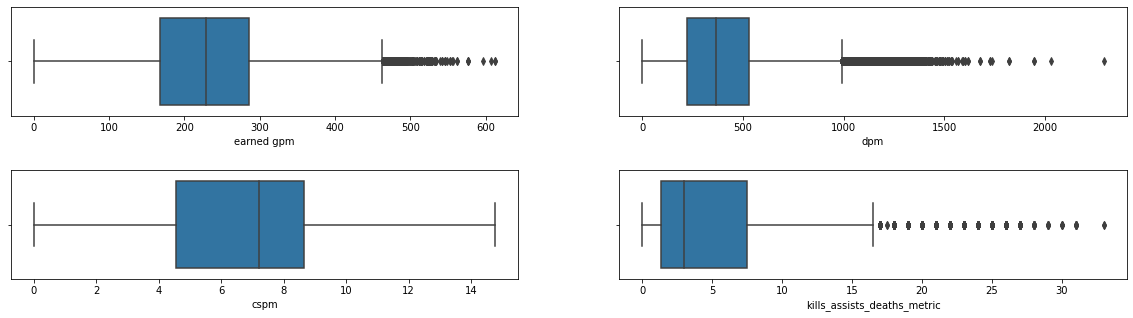

In [13]:
fig = plt.figure(figsize = (20,5))
fig.subplots_adjust(hspace=0.5, wspace=0.2)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(df['earned gpm'], ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(df['dpm'], ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.boxplot(df['cspm'], ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.boxplot(df['kills_assists_deaths_metric'], ax=ax)

plt.show()

### Split df per position (top, jng, mid, bot, sup) and keep only relevant features

In [14]:
columns = ['year','playername','position','earned gpm', 'dpm', 'cspm', 'kills_assists_deaths_metric', 'result','target']

#create df per position
df_top = df.loc[df['position']=='top',columns]
df_jng = df.loc[df['position']=='jng',columns]
df_mid = df.loc[df['position']=='mid',columns]
df_bot = df.loc[df['position']=='bot',columns]
df_sup = df.loc[df['position']=='sup',columns]

In [15]:
df_top.head(5)

,year,playername,position,earned gpm,dpm,cspm,kills_assists_deaths_metric,result,target
0,2014,Yazuki,top,194.9940,423.6769,7.5686,3.500000,0,1
5,2014,Jezie,top,245.9212,290.7123,6.6375,5.333333,1,0
11,2014,Jezie,top,183.3990,463.0260,5.3413,2.500000,1,0
17,2014,Yazuki,top,241.1823,687.1499,7.7692,10.000000,0,1
22,2014,Sphinx,top,186.3969,466.1892,6.9874,1.000000,0,0


## Functions to Preprocess data

In [16]:
def create_train_test_tensors(df):
    ''' this function creates train and test sets'''
    
    # list the first year each player is active in a df
    name_year_list = df[['playername','year','target']].groupby(by="playername").min()
    name_year_list = name_year_list.reset_index()
    
    #create tensor with matches for first year of each player
    tensor = []
    #features = ['earned gpm', 'dpm', 'cspm', 'kills_assists_deaths_metric', 'result','playername','target']
    features = ['result','playername','target']
    for index, row in name_year_list.iterrows():
        tensor.append(df.loc[(df['playername']==row['playername'])&(df['year']==row['year']), features])
        
    # Create X and y
    X = np.array(tensor, dtype=object)
    y = name_year_list['target'].astype('int32')
    
    #split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    return X_train, X_test, y_train, y_test

In [17]:
def preprocess_data(X_train, X_test):
    
    #untensor train and test data. Create long list of all matches. This has to be done for the scaling.
    X_train_untensored = pd.DataFrame()
    for player in range(len(X_train)):
        X_train_untensored = pd.concat([X_train_untensored, X_train[player]])
        
    X_test_untensored = pd.DataFrame()
    for player in range(len(X_test)):
        X_test_untensored = pd.concat([X_test_untensored, X_test[player]])
    
    #create preprocessing pipeline for Imputing then scaling numerical values: 
    num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
    preprocessing = make_column_transformer(
        #(num_transformer, ['earned gpm', 'dpm', 'cspm', 'kills_assists_deaths_metric', 'result']),
        (num_transformer, ['result']),
        #(cat_transformer, cat_col),
        remainder='passthrough')
    
    # fit & scale train data. Only scale test data.
    X_train_transformed = pd.DataFrame(preprocessing.fit_transform(X_train_untensored))
    X_test_transformed = pd.DataFrame(preprocessing.transform(X_test_untensored))
    
    #make tensor again for train and test data
    features = [0]

    unique_players_train = X_train_transformed[1].unique()
    X_train_tensor = []
    for name in unique_players_train:
        X_train_tensor.append(X_train_transformed.loc[(X_train_transformed[1]==name), features])
        
    unique_players_test = X_test_transformed[1].unique()
    X_test_tensor = []
    for name in unique_players_test:
        X_test_tensor.append(X_test_transformed.loc[(X_test_transformed[1]==name), features])
        
    # Padding train and test data
    X_train_preprocessed = pad_sequences(np.array(X_train_tensor, dtype=object), dtype='float32', padding = 'post', value=-1000, maxlen=150) # int32 by default
    X_test_preprocessed = pad_sequences(np.array(X_test_tensor, dtype=object), dtype='float32', padding = 'post', value=-1000, maxlen=150) # int32 by default
    
    return X_train_preprocessed, X_test_preprocessed

In [18]:
def oversample_train_data(X_train_preprocessed, y_train):

    # define oversampling strategy
    oversample = RandomOverSampler(sampling_strategy=0.3)
    
    (a,b,c) = X_train_preprocessed.shape

    #shape and reshape
    X_train_reshape = X_train_preprocessed.reshape(a, b * c)
    
    # fit and apply the transform
    X_train_over, y_train_over = oversample.fit_resample(X_train_reshape, y_train)
    (d,e) = X_train_over.shape
    
    X_train_over = X_train_over.reshape(d, b, c)
    
    return X_train_over, y_train_over

## Preprocess data

### 0. Process data for all players

In [19]:
#create X and y data
X_all_train, X_all_test, y_all_train, y_all_test = create_train_test_tensors(df)

#preprocess X_train and X_test
X_all_train_preprocessed, X_all_test_preprocessed = preprocess_data(X_all_train, X_all_test)
print(f"Shape of preprocessed X_train and X_test data for all players:")
print(X_all_train_preprocessed.shape, X_all_test_preprocessed.shape)

#oversample train data
#X_all_train_over, y_all_train_over = oversample_train_data(X_all_train_preprocessed, y_all_train)
#print(f"\n Shape of oversampled X_train and y_train data for all players:")
#print(X_all_train_over.shape, y_all_train_over.shape)

Shape of preprocessed X_train and X_test data for all players:
(2165, 150, 1) (928, 150, 1)


### 1. Process data for "top" players

In [ ]:
#create X and y data
X_top_train, X_top_test, y_top_train, y_top_test = create_train_test_tensors(df_top)

#preprocess X_train and X_test
X_top_train_preprocessed, X_top_test_preprocessed = preprocess_data(X_top_train, X_top_test)
print(f"Shape of preprocessed X_train and X_test data for 'top' players:")
print(X_top_train_preprocessed.shape, X_top_test_preprocessed.shape)

#oversample train data
#X_top_train_over, y_top_train_over = oversample_train_data(X_top_train_preprocessed, y_top_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'top' players:")
#print(X_top_train_over.shape, y_top_train_over.shape)

### 2. Process data for "jng" players

In [ ]:
#create X and y data
X_jng_train, X_jng_test, y_jng_train, y_jng_test = create_train_test_tensors(df_jng)

#preprocess X_train and X_test
X_jng_train_preprocessed, X_jng_test_preprocessed = preprocess_data(X_jng_train, X_jng_test)
print(f"Shape of preprocessed X_train and X_test data for 'jng' players:")
print(X_jng_train_preprocessed.shape, X_jng_test_preprocessed.shape)

#oversample train data
#X_jng_train_over, y_jng_train_over = oversample_train_data(X_jng_train_preprocessed, y_jng_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'top' players:")
#print(X_jng_train_over.shape, y_jng_train_over.shape)

### 3. Process data for "mid" players

In [ ]:
#create X and y data
X_mid_train, X_mid_test, y_mid_train, y_mid_test = create_train_test_tensors(df_mid)

#preprocess X_train and X_test
X_mid_train_preprocessed, X_mid_test_preprocessed = preprocess_data(X_mid_train, X_mid_test)
print(f"Shape of preprocessed X_train and X_test data for 'mid' players:")
print(X_mid_train_preprocessed.shape, X_mid_test_preprocessed.shape)

#oversample train data
#X_mid_train_over, y_mid_train_over = oversample_train_data(X_mid_train_preprocessed, y_mid_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'mid' players:")
#print(X_mid_train_over.shape, y_mid_train_over.shape)

### 4. Process data for "bot" players

In [ ]:

#create X and y data
X_bot_train, X_bot_test, y_bot_train, y_bot_test = create_train_test_tensors(df_bot)

#preprocess X_train and X_test
X_bot_train_preprocessed, X_bot_test_preprocessed = preprocess_data(X_bot_train, X_bot_test)
print(f"Shape of preprocessed X_train and X_test data for 'bot' players:")
print(X_bot_train_preprocessed.shape, X_bot_test_preprocessed.shape)

#oversample train data
#X_bot_train_over, y_bot_train_over = oversample_train_data(X_bot_train_preprocessed, y_bot_train)
#print(f"\n Shape of oversampled X_train and y_train data for 'bot' players:")
#print(X_bot_train_over.shape, y_bot_train_over.shape)

### 5. Process data for "sup" players

In [ ]:
#create X and y data
X_sup_train, X_sup_test, y_sup_train, y_sup_test = create_train_test_tensors(df_sup)

#preprocess X_train and X_test
X_sup_train_preprocessed, X_sup_test_preprocessed = preprocess_data(X_sup_train, X_sup_test)
print(f"Shape of preprocessed X_train and X_test data for 'sup' players:")
print(X_sup_train_preprocessed.shape, X_sup_test_preprocessed.shape)

#oversample train data
#X_sup_train_over, y_sup_train_over = oversample_train_data(X_sup_train_preprocessed, y_sup_train)
#print(f"\n Shape of oversampled X_test and y_test data for 'sup' players:")
#print(X_sup_train_over.shape, y_sup_train_over.shape)

## RNN model

### Functions for metrics and plotting results

In [20]:
# function for defining the f1-metric
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [21]:
#functions for plotting the model.fit history

def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
def plot_history2(history):
    plt.plot(history.history['f1_metric'])
    plt.plot(history.history['val_f1_metric'])
    plt.title('Model f1 score')
    plt.ylabel('f1 score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
def plot_history3(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
def plot_history4(history):
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model recall')
    plt.ylabel('recall')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

### Fitting the model

In [22]:
y_all_train.value_counts()

0    1430
1     735
Name: target, dtype: int64

In [23]:
702/(1463+702)

0.32424942263279444

In [24]:
y_all_test.value_counts()

0    650
1    278
Name: target, dtype: int64

In [25]:
311/(617+311)

0.33512931034482757

In [26]:
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reg_l2 = regularizers.L2(0.02)

(a,b,c) = X_all_train_preprocessed.shape

# –– Model
model = Sequential()
model.add(layers.Masking(mask_value=-1000, input_shape=(b, c)))
model.add(layers.LSTM(units=10, activation='tanh', recurrent_dropout=0.3)) #LSTM (recurrent or dropout) or GRU, tanh as activation
#model.add(layers.SimpleRNN(2, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# –– Compilation
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy','Precision','Recall'])

# –– Fit
history = model.fit(X_all_train_preprocessed, y_all_train, 
          epochs=100, 
          validation_split = 0.3,
          callbacks=[es]); #check if we can make the early stopping on the f1-metric of the validation -> monitor?

#plot_history2(history)

2022-09-08 10:18:59.521899: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
48/48 [==============================] - 10s 135ms/step - loss: 0.6957 - accuracy: 0.4706 - precision: 0.2465 - recall: 0.2724 - val_loss: 0.6672 - val_accuracy: 0.6600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
48/48 [==============================] - 6s 128ms/step - loss: 0.6310 - accuracy: 0.6607 - precision: 0.5000 - recall: 0.0019 - val_loss: 0.6139 - val_accuracy: 0.6646 - val_precision: 0.6364 - val_recall: 0.0317
Epoch 3/100
48/48 [==============================] - 7s 151ms/step - loss: 0.5906 - accuracy: 0.6779 - precision: 0.6548 - recall: 0.1070 - val_loss: 0.6032 - val_accuracy: 0.6862 - val_precision: 0.6269 - val_recall: 0.1900
Epoch 4/100
48/48 [==============================] - 7s 153ms/step - loss: 0.5803 - accuracy: 0.6944 - precision: 0.6409 - recall: 0.2257 - val_loss: 0.5992 - val_accuracy: 0.6969 - val_precision: 0.6154 - val_recall: 0.2896
Epoch 5/100
48/48 [==============================] - 6s 129ms/step - loss: 0.5753 - accurac

In [45]:
model.evaluate(X_all_test_preprocessed,y_all_test)

29/29 [==============================] - 1s 15ms/step - loss: 0.5463 - accuracy: 0.7263 - f1_metric: 0.5051 - precision: 0.6351 - recall: 0.4309


[0.5462731122970581,
 0.7262930870056152,
 0.5050623416900635,
 0.6350710988044739,
 0.4308681786060333]

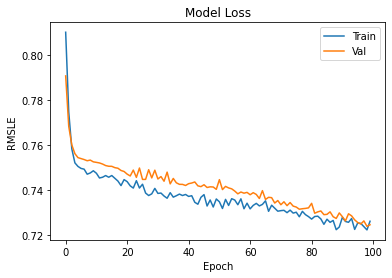

In [46]:
plot_history(history)

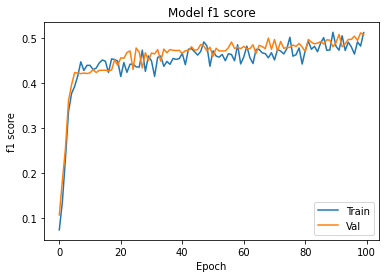

In [47]:
plot_history2(history)

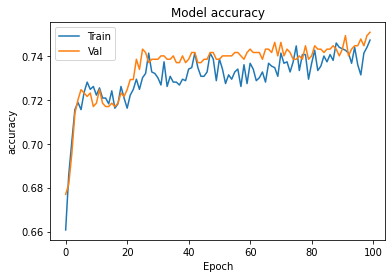

In [48]:
plot_history3(history)

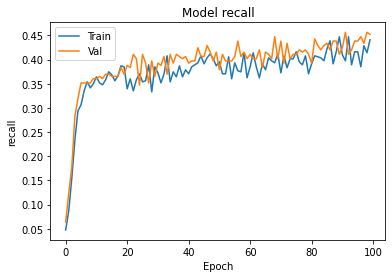

In [49]:
plot_history4(history)

In [27]:
model.save('my_model2.h5')

# OLD

### f1 baseline score (0)

In [ ]:
y_pred_test = model.predict(X_bot_test_preprocessed)

In [ ]:
#always predict 0, estimate the f1-score => baseline

#pred_all_0 = 
pred_top_0 = y_top_test.copy()
pred_top_0[pred_top_0 > 0] = 0

pred_jng_0 = y_jng_test.copy()
pred_jng_0[pred_jng_0 > 0] = 0

pred_mid_0 = y_mid_test.copy()
pred_mid_0[pred_mid_0 > 0] = 0

pred_bot_0 = y_bot_test.copy()
pred_bot_0[pred_bot_0 > 0] = 0

pred_sup_0 = y_sup_test.copy()
pred_sup_0[pred_sup_0 > 0] = 0

#estimate baseline f1 score
baseline_all_f1 = "X" #f1_metric(y_all_test, y_pred)
baseline_top_f1 = f1_metric(y_top_test.astype('float32'), pred_top_0.astype('float32'))
baseline_jng_f1 = f1_metric(y_jng_test.astype('float32'), pred_jng_0.astype('float32'))
baseline_mid_f1 = f1_metric(y_mid_test.astype('float32'), pred_mid_0.astype('float32')) 
baseline_bot_f1 = f1_metric(y_bot_test.astype('float32'), pred_bot_0.astype('float32'))
baseline_sup_f1 = f1_metric(y_sup_test.astype('float32'), pred_sup_0.astype('float32'))

#print baseline f1 results
print(f"f1 baseline scores")
print(f"top: {baseline_top_f1}, jng: {baseline_jng_f1}, mid: {baseline_mid_f1}, bot: {baseline_bot_f1}, sup: {baseline_sup_f1}")

In [ ]:
y_top_test.value_counts()

In [ ]:
# baseline accuracy
#1 – (Number of misclassified samples / Total number of samples).

baseline_accuracy_bot = 1 - len(y_bot_test[y_bot_test==1])/len(y_bot_test)
baseline_accuracy_bot

### Dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
# create dummy classifier
dummy_clf = DummyClassifier(strategy='uniform', random_state=0)
# train a model
dummy_clf.fit(X_bot_train_over, y_bot_train_over)
# get accuracy score
dummy_clf.score(X_bot_test_preprocessed, y_bot_test)

In [ ]:
# Impute then scale numerical values: 
num_transformer = make_pipeline(SimpleImputer(), StandardScaler())

# Encode categorical values (do we have these?)
#cat_transformer = OneHotEncoder()

# Select automatically features based on dtype, or put in column names manually
num_col = make_column_selector(dtype_include=['float64'])
#cat_col = make_column_selector(dtype_include=['object','bool'])

## Parallelize "num_transformer" and "cat_transfomer"
preproc = make_column_transformer(
    (num_transformer, ['earned gpm', 'dpm', 'cspm', 'kills_per_min', 'assists_per_min', 'deaths_per_min', 'result'])
    #(cat_transformer, cat_col),
    #remainder='passthrough'
)

# Visualizing Pipelines in HTML
preproc

In [ ]:
#check new transformed dataframe
X_train_transformed = preproc.fit_transform(X_top_train)
X_train_transformed.shape
#pd.DataFrame(
#    X_train_transformed, 
#    columns=preproc.get_feature_names_out()
#).head()

In [ ]:
y_top_train

## Model

### 2A. Model

In [ ]:
# Import the model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier 

# Select model to use
model = LogisticRegression(max_iter=1000)
#model = SGDClassifier(loss='hinge', penalty='l2', alpha=1/10)

# Make pipeline
pipe = make_pipeline(preproc, model)
pipe

# Train Pipeline ⇒ with training data (~70% of full dataset). 
# Deselected as we want to grid search for best params.
pipe.fit(X_top_train, y_top_train)

In [ ]:
from sklearn.neighbors import KNeighborsClassifire

In [ ]:
model = KNeighborsClassifier(n_neighbors=15)

model.fit(X_train_transformed, y_top_train)
y_pred_test = model.predict(X_top_test)
pd.DataFrame(y_pred_test).value_counts()

In [ ]:
model.score(X_top_test, y_top_test)

In [ ]:
X_top_test.shape, X_top_train.shape, y_top_test.shape, y_top_train.shape

In [ ]:
y_pred = pipe.predict(X_top_test)
pd.DataFrame(y_pred).value_counts()

In [ ]:
pipe.score(X_top_test, y_top_test)

In [ ]:
pipe.score(X_top_test, y_top_test)

In [ ]:
#pipe.evaluate(X_top_test,np.ravel(y_top_test.to_numpy()))
cross_val_score(pipe, X_top_train, y_top_train, cv=5, scoring='r2').mean()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Inspect the parameters of all of the pipe's components to find the one you want to Grid Search
print(pipe.get_params())

# Instantiate Grid Search
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        # Access any component of the Pipeline, as far back as you want
        'columntransformer__pipeline__simpleimputer__strategy': ['mean', 'median'],
        'ridge__alpha': [0.1, 0.5, 1, 5, 10]
    },
    cv=5,
    scoring="r2")

grid_search.fit(X_top_train, np.ravel(y_top_train.to_numpy()))

grid_search.best_params_

pipe_tuned = grid_search.best_estimator_

### 3. Evaluate (Cross validate)

In [ ]:
from sklearn.model_selection import cross_val_score

# Evaluate the model with testing data (~30%)
print(pipe.score(X_test,y_test))

# Cross-validate Pipeline
print(cross_val_score(pipe, X_top_train, y_train, cv=5, scoring='r2').mean())

## AutoML with TPOT
TPOT - The Tree-based Pipeline Optimization Tool (TPOT) is an automated Machine Learning tool that optimizes Machine Learning Pipelines

In [ ]:
import os
from tpot import TPOTRegressor

In [ ]:
## Preprocess
X_train_preproc = preproc.fit_transform(X_top_train)
X_test_preproc = preproc.transform(X_top_test)

# Instantiate TPOTClassifier
tpot = TPOTRegressor(generations=4, population_size=20, verbosity=2, scoring='r2', n_jobs=-1, cv=2)

# Process autoML with TPOT
tpot.fit(X_train_preproc, y_top_train)

# Print score
print(tpot.score(X_test_preproc, y_top_test))

# Export TPOT Pipeline to a Python file
#tpot.export(os.path.join(os.getcwd(),'tpot_iris_pipeline.py'))
#! cat 'tpot_iris_pipeline.py'

# Cross-validate Pipeline --> check if this works
print(cross_val_score(tpot, X_train_preproc, y_top_train, cv=5, scoring='r2').mean())